## Imports

In [1]:
import os

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.notebook import trange

# from custom files
from others.dataset import CompCarsImageFolder, WrapperDataset, ImagesFromTextFile
from models.resnet import ResNet, resnet_cfg, train, validate
from others.utils import fix_all_seeds, train_val_dataset, show_plot

## Configuration

In [2]:
###### Set root to the image folder of CompCars dataset ######

### NOTE: ADAPT TO YOUR FOLDER STRUCTURE
## EDO'S PATHS
root = '/Volumes/EDO/NNDL/CompCars dataset/data/image/'
train_file = '/Volumes/EDO/NNDL/CompCars dataset/data/train_test_split/classification/train.txt'
test_file = '/Volumes/EDO/NNDL/CompCars dataset/data/train_test_split/classification/test.txt'

## MICHAEL'S PATHS
# root = '../cars_data/data/image/'
# train_file = '../cars_data/data/train_test_split/classification/train.txt'
# test_file = '../cars_data/data/train_test_split/classification/test.txt'

#############################################################

### Hyperparam configuration

resnet_type = 'resnet50'                # 'resnet18', 'resnet34', 'resnet50'    

params = {                              ## Training Params (inspired from original resnet paper: https://arxiv.org/pdf/1512.03385)
    'epoch_num': 50,                    # number of epochs
    'lr': 1e-1,                         # (initial) Learning Rate
    'weight_decay': 1e-4,               # L2 Penalty
    'batch_size': 256,                  # batch size (tune depending on hardware)
    'momentum': 0.9,
    
    'hierarchy': 0,                     # Choose 0 for manufacturer classification, 1 for model classification
    'val_split': 10000,                 # (float) Fraction of validation holdout set / (int) Absolute number of data points in holdout set
    
    'resnet': resnet_cfg[resnet_type],  # ResNet configuration

    'use_train_test_split': False,      # True: use prepared split, False: use total dataset

    'seed': 28,                         # for reproducibility (NOTE: may be still non-deterministic for multithreaded/multiprocess stuff, e.g. DataLoader)
}
# !!! NOTE: REMEMBER TO PASS SEED TO train_val_dataset FUNCTION AS ARGUMENT !!! 
fix_all_seeds(seed=params['seed'])

### Device
if torch.cuda.is_available():
    params["device"] = torch.device("cuda")   # option for NVIDIA GPUs
elif torch.backends.mps.is_available():
    params["device"] = torch.device("mps")    # option for Mac M-series chips (GPUs)
else:
    params["device"] = torch.device("cpu")    # default option if none of the above devices are available

print("Device: {}".format(params["device"]))

Device: mps


# Data Pipeline (prepared train-test-split)

## Read train/test text files separately

In [3]:
### Load prepared train_test_split
train_set = ImagesFromTextFile(root, txt_file=train_file, hierarchy=params['hierarchy'])
print(train_set.classes)
print(len(train_set.classes))

test_set = ImagesFromTextFile(root, txt_file=test_file, hierarchy=params['hierarchy'])
print(test_set.classes)
print(len(test_set.classes))

['100', '102', '103', '105', '106', '108', '11', '111', '114', '118', '119', '120', '121', '122', '128', '131', '132', '133', '134', '138', '14', '140', '142', '148', '149', '15', '150', '152', '155', '157', '158', '159', '160', '162', '26', '27', '28', '29', '34', '35', '36', '37', '38', '39', '4', '43', '45', '48', '50', '51', '53', '54', '55', '58', '64', '68', '69', '70', '71', '73', '75', '76', '77', '78', '80', '81', '82', '84', '87', '88', '89', '92', '94', '95', '97']
75
['100', '102', '103', '105', '106', '108', '11', '111', '114', '118', '119', '120', '121', '122', '128', '131', '132', '133', '134', '138', '14', '140', '142', '148', '149', '15', '150', '152', '155', '157', '158', '159', '160', '162', '26', '27', '28', '29', '34', '35', '36', '37', '38', '39', '4', '43', '45', '48', '50', '51', '53', '54', '55', '58', '64', '68', '69', '70', '71', '73', '75', '76', '77', '78', '80', '81', '82', '84', '87', '88', '89', '92', '94', '95', '97']
75


## Raw Data Visualization

Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (909, 627)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (907, 626)


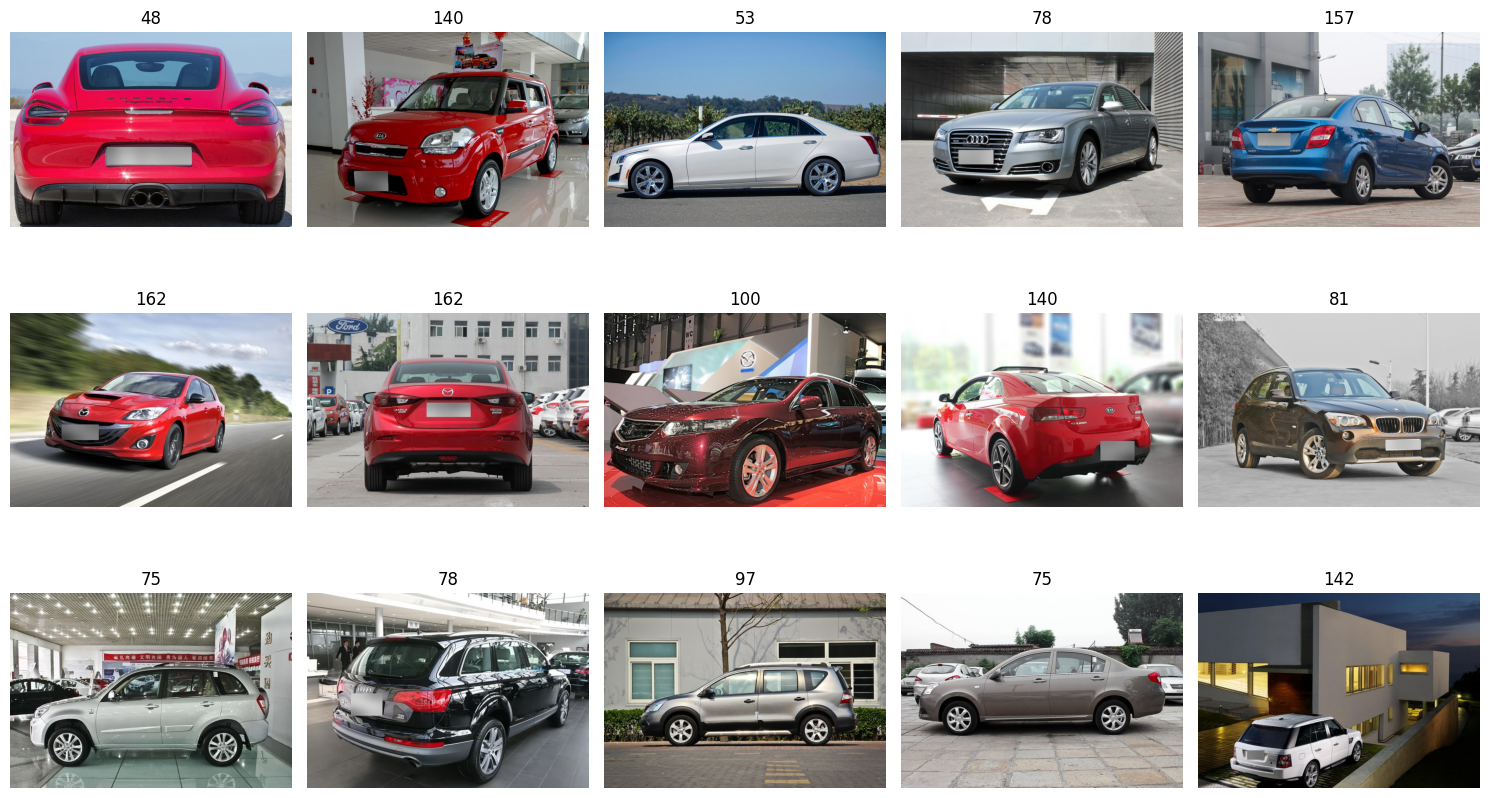

In [4]:
# Visualization of the train dataset
label_dict = {y: x for x, y in train_set.class_to_idx.items()}

num_images_to_show = 15
data_idx = np.random.randint(0, high=len(train_set), size=num_images_to_show)
num_cols = 5
num_rows = num_images_to_show // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()
for i in range(num_images_to_show):
    image, label = train_set[data_idx[i]]
    np_img = np.array(image)
    axes[i].imshow(np_img)
    axes[i].set_title(label_dict[label])
    axes[i].axis('off')
    print(f"Image shape: {image.size}")
plt.tight_layout()
plt.show()

# Data Pipeline (full data set)

## Read total Dataset

In [5]:
### Load full dataset
# hierarchy=0 -> manufacturer classification; hierarchy=1 -> model classification
total_set = CompCarsImageFolder(root, hierarchy=params['hierarchy'])
print(total_set.classes)
print(len(total_set.classes))

### Train-Validation Split (returns Subset objects)
######### !!! NOTE: PASS SEED TO KEEP TRAIN/VALIDATION SPLIT THE SAME !!! ################
datasets = train_val_dataset(total_set, val_split=params['val_split'], seed=params['seed'])

KeyboardInterrupt: 

## Raw Data Visualization

In [ ]:
# Visualization of the dataset
label_dict = {y: x for x, y in total_set.class_to_idx.items()}

num_images_to_show = 15
data_idx = np.random.randint(0, high=len(total_set), size=num_images_to_show)
num_cols = 5
num_rows = num_images_to_show // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()
for i in range(num_images_to_show):
    image, label = total_set[data_idx[i]]
    np_img = np.array(image)
    axes[i].imshow(np_img)
    axes[i].set_title(label_dict[label])
    axes[i].axis('off')
    print(f"Image shape: {image.size}")
plt.tight_layout()
plt.show()

## Compute normalization statistics

### TODO: recompute normalization for chosen seed

In [ ]:
'''
NOTE: This cell takes some time. Could be accelerated by:
    1. Using dataloader (vectorized batches)
    2. Resize images before computing statistics
    3. Use fixed values computed once (with fixed seed) TODO 
'''

# TODO: Recompute once with fixed seed
if params['use_train_test_split']:
    # resulting values from the lines below
    train_mean, train_std = [0.4913, 0.4796, 0.4696], [0.2873, 0.2860, 0.2914]
    val_mean, val_std = [0.4919, 0.4797, 0.4693], [0.2879, 0.2869, 0.2923]

    # Compute mean and std for training dataset
    # train_mean, train_std = compute_mean_std_from_dataset(train_set)
    # print(f"Training dataset mean: {train_mean}")
    # print(f"Training dataset std: {train_std}")

    # Compute mean and std for validation dataset
    # val_mean, val_std = compute_mean_std_from_dataset(test_set)
    # print(f"Validation dataset mean: {val_mean}")
    # print(f"Validation dataset std: {val_std}")
    
else:
    # default (computed statistic on whole dataset)
    mean, std = [0.483, 0.471, 0.463], [0.297, 0.296, 0.302]

    # Compute mean and std for training dataset
    # train_mean, train_std = compute_mean_std_from_dataset(datasets['train'])
    # print(f"Training dataset mean: {train_mean}")
    # print(f"Training dataset std: {train_std}")
    train_mean, train_std = mean, std

    # Compute mean and std for validation dataset
    # val_mean, val_std = compute_mean_std_from_dataset(datasets['val'])
    # print(f"Validation dataset mean: {val_mean}")
    # print(f"Validation dataset std: {val_std}")
    val_mean, val_std = mean, std

## Transform data - Prepare DataLoaders

In [ ]:
# Apply transformation
########################## Transforms ############################
# TODO: maybe use v2 transforms: https://pytorch.org/vision/stable/transforms.html

# Augmentation Strategy similar to original ResNet paper: https://arxiv.org/pdf/1512.03385
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomChoice([       # Scale Augmentation
            transforms.Resize(256),
            transforms.Resize(224),
            transforms.Resize(320)
        ]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(224),     # ResNet expects 224x224 images
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),     # Evaluate using 224x224 central part of image
        transforms.ToTensor(),
        transforms.Normalize(val_mean, val_std)
    ])
}
##################################################################

# Wrapper dataset used to make reading/splitting dataset independent of applying transform
if params['use_train_test_split']:
    wrapped_datasets = {
        'train': WrapperDataset(train_set, transform=data_transforms['train']),
        'val': WrapperDataset(test_set, transform=data_transforms['val'])
    }
else:
    wrapped_datasets = {
        'train': WrapperDataset(datasets['train'], transform=data_transforms['train']),
        'val': WrapperDataset(datasets['val'], transform=data_transforms['val'])
    }

# NOTE: for num_workers != 0 dataloader won't be deterministic (for reproducible implementation see https://pytorch.org/docs/stable/notes/randomness.html)
dataloaders = {
    'train': DataLoader(wrapped_datasets['train'], batch_size=params['batch_size'], shuffle=True, num_workers=os.cpu_count()), # NOTE: num_workers to tune for performance or reproducibility
    'val': DataLoader(wrapped_datasets['val'], batch_size=params['batch_size'], shuffle=False, num_workers=os.cpu_count())
}


print(f"Training dataset size: {len(wrapped_datasets['train'])}")
print(f"Validation dataset size: {len(wrapped_datasets['val'])}")

x, y, _ = next(iter(dataloaders['train']))
print(f"Batch of training images shape: {x.shape}")
print(f"Batch of training labels shape: {y.shape}")

x, y, _ = next(iter(dataloaders['val']))
print(f"Batch of validation images shape: {x.shape}")
print(f"Batch of validation labels shape: {y.shape}")

# Training

## Set-Up

In [ ]:
# Set up resnet model
if params['use_train_test_split']:
    num_classes = len(train_set.classes)
else:
    num_classes = len(total_set.classes)

model = ResNet(params['resnet']['block'], params['resnet']['layers'], 
            num_classes).to(params['device'])

# Loss and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=params['lr'], 
    weight_decay=params['weight_decay'], 
    momentum=params['momentum']
)

# optimizer = torch.optim.Adam(
#     resnet.parameters(), 
#     lr=params['lr'], 
#     weight_decay=params['weight_decay']
# )

# LR scheduler (using Top-1-Accuracy as Validation metric)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, min_lr=1e-4, patience=3, threshold=1e-3)

# Save performance metrics
train_losses, validation_losses, train_acc, validation_acc, train_top5_acc, validation_top5_acc = list(), list(), list(), list(), list(), list()

## Training Loop

To start from checkpoint, set `START_FROM_CHECKPOINT=True`.

In [ ]:
CHECKPOINT_PATH = './training_checkpoints/checkpoint.pth'
START_FROM_CHECKPOINT = False
start_epoch = 0

if START_FROM_CHECKPOINT:
    checkpoint = torch.load(CHECKPOINT_PATH)
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    train_losses = checkpoint['train_losses']
    train_acc = checkpoint['train_acc']
    train_top5_acc = checkpoint['train_top5_acc']
    validation_losses = checkpoint['validation_losses']
    validation_acc = checkpoint['validation_acc']
    validation_top5_acc = checkpoint['validation_top5_acc']

# Just some fancy progress bars
pbar_epoch = trange(start_epoch, params["epoch_num"], initial=start_epoch, total=params["epoch_num"], desc="Training", position=0, leave=True, unit="epoch", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_inv_fmt}]")
pbar_inside_epoch = trange(0, (len(dataloaders['train'])+len(dataloaders['val'])), desc="Training and validation per epoch", position=1, leave=False, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_inv_fmt}]")

# Stop the training phase in case there is no improvement
# early_stopper = EarlyStopper(patience=10, min_delta=0.1)

for epoch in pbar_epoch:
    pbar_inside_epoch.reset()

    # Training
    train_results = train(dataloaders['train'], model, epoch, criterion, optimizer, params["device"], pbar_notebook=pbar_inside_epoch)
    train_losses.append(train_results[0])
    train_acc.append(1 - train_results[1])                 # saving acc error
    train_top5_acc.append(1 - train_results[2])

    # Validation
    validation_results = validate(dataloaders['val'], model, epoch, criterion, params["device"], pbar_notebook=pbar_inside_epoch)
    validation_losses.append(validation_results[0])
    validation_acc.append(1 - validation_results[1])       # saving acc error
    validation_top5_acc.append(1 - validation_results[2])

    # Scheduler
    scheduler.step(validation_results[1])   # ReduceLROnPlateau scheduler (reduce LR by 10 when top-1-accuracy does not improve)
    print("\nCurrent Learning Rate: ", round(scheduler.get_last_lr()[0], 4), "\n")

    # Checkpoint
    torch.save({
        'epoch' : epoch + 1,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict' : scheduler.state_dict(),
        'train_losses': train_losses,
        'train_acc': train_acc,
        'train_top5_acc': train_top5_acc,
        'validation_losses': validation_losses,
        'validation_acc': validation_acc,
        'validation_top5_acc': validation_top5_acc,
    }, CHECKPOINT_PATH)

    # Comment on the following lines if you don't want to stop early in case of no improvement
    # if early_stopper.early_stop(validation_results[0]):
    #     params['epoch_num'] = epoch
    #     print("\n\nEarly stopping...")
    #     break

pbar_inside_epoch.close()

## Plot losses

In [ ]:
# Plotting the performance of the model in the training and validation phase

plots = [
    (np.arange(0, len(train_losses), 1), train_losses, "Train Loss"),
    (np.arange(0, len(validation_losses), 1), validation_losses, "Validation Loss")
]

show_plot(plots, "Model Loss for Epoch", "Epoch", "Loss")

plots = [
    (np.arange(0, len(train_acc), 1), train_acc, "Train Top-1-Error"),
    (np.arange(0, len(validation_acc), 1), validation_acc, "Validation Top-1-Error"),
    (np.arange(0, len(train_top5_acc), 1), train_top5_acc, "Train Top-5-Error"),
    (np.arange(0, len(validation_top5_acc), 1), validation_top5_acc, "Validation Top-5-Error")
]

show_plot(plots, "Model Classification Error for Epoch", "Epoch", "Error Rate")

## Save Model

In [ ]:
MODEL_PATH = './trained_models/' + resnet_type + '_weights_car_'

if params['hierarchy'] == 0:
    MODEL_PATH += 'makers_'
else:
    MODEL_PATH += 'models_'

MODEL_PATH += 'full_dataset_'

MODEL_PATH += str(params['batch_size']) + '.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses,
    'train_acc': train_acc,
    'train_top5_acc': train_top5_acc,
    'validation_losses': validation_losses,
    'validation_acc': validation_acc,
    'validation_top5_acc': validation_top5_acc,
    'resnet': params['resnet'],
}, MODEL_PATH)

# Load and Evaluate Saved Model

## Load

In [ ]:
# path to the saved model TO BE CHANGED
MODEL_PATH = './trained_models/model.pth'
saved_model = torch.load(MODEL_PATH, map_location=params['device'])

if params['use_train_test_split']:
    num_classes = len(train_set.classes)
else:
    num_classes = len(total_set.classes)

model = ResNet(saved_model['resnet']['block'], saved_model['resnet']['layers'], 
                num_classes).to(params['device'])

model.load_state_dict(saved_model['model_state_dict'])
train_losses = saved_model['train_losses']
train_acc = saved_model['train_acc']
train_top5_acc = saved_model['train_top5_acc']
validation_losses = saved_model['validation_losses']
validation_acc = saved_model['validation_acc']
validation_top5_acc = saved_model['validation_top5_acc']

## Plot performance data

In [ ]:
# Plotting the performance of the model in the training and validation phase

plots = [
    (np.arange(0, len(train_losses), 1), train_losses, "Train Loss"),
    (np.arange(0, len(validation_losses), 1), validation_losses, "Validation Loss")
]

show_plot(plots, "Model Loss for Epoch", "Epoch", "Loss")

plots = [
    (np.arange(0, len(train_acc), 1), train_acc, "Train Top-1-Error"),
    (np.arange(0, len(validation_acc), 1), validation_acc, "Validation Top-1-Error"),
    (np.arange(0, len(train_top5_acc), 1), train_top5_acc, "Train Top-5-Error"),
    (np.arange(0, len(validation_top5_acc), 1), validation_top5_acc, "Validation Top-5-Error")
]

show_plot(plots, "Model Classification Error for Epoch", "Epoch", "Error Rate")